In [2]:
import itertools 
import string

import numpy as np
from nltk.tokenize import WordPunctTokenizer

from matplotlib import pyplot as plt
from IPython.display import clear_output  

In [3]:
data = list(open("quora.txt", encoding = "utf-8"))
tokenizer = WordPunctTokenizer()
data_tok = [tokenizer.tokenize(sentence.lower()) for sentence in data] 

In [4]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into list of tokens(strings)"
is_latin = lambda tok: all( 'a' <= x.lower() <= 'x' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, data_tok))), "please make sure to lowercase the data"

In [5]:
import gensim.downloader as api
model = api.load('glove-twitter-25')
words = sorted(model.index_to_key,
              key = lambda word : model.get_vecattr(word, "count"),
              reverse=True)[:1000]
              
word_vectors = np.array([model.get_vector(word) for word in words])

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
pca = PCA(2)
scaler = StandardScaler() 

word_vectors_pca = pca.fit_transform(word_vectors)
word_vectors_pca = scaler.fit_transform(word_vectors_pca)

In [7]:
assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "points must be zer-centered"
assert max(abs(1.0 - word_vectors_pca.std(0))) < 1e-2, "points must have unit varience"

In [8]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius = 10, alpha = 0.25, color = 'blue', 
                 width = 600, height = 400, show = True, **kwargs):
  if isinstance(color, str): color = [color]*len(x)
  data_source = bm.ColumnDataSource({'x' : x, 'y' : y, 'color':color, **kwargs})

  fig = pl.figure(active_scroll='wheel_zoom', width = width, height = height)
  fig.scatter('x', 'y', size = radius, color = 'color', alpha = alpha, source = data_source)

  fig.add_tools(bm.HoverTool(tooltips = [(key, "@"+key) for key in kwargs.keys()]))
  if show: pl.show(fig)
  return fig

Loading BokehJS ...

In [9]:
import umap.umap_ as umap

/Users/sofiagureva/miniconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sofiagureva/miniconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sofiagureva/miniconda3/lib/python3.9/site-packages/umap/distances.py:1086: 

In [14]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(word_vectors)
draw_vectors(embedding[:, 0], embedding[:, 1], token = words)

figure(id='p1049', ...)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from ripser import ripser, Rips
from persim import plot_diagrams

In [12]:
r = ripser(embedding)
dgms = r['dgms']

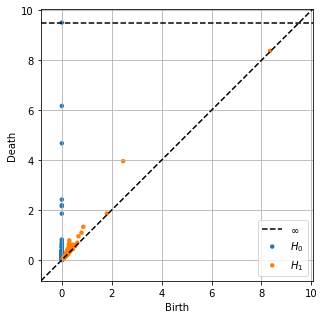

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.grid()
plot_diagrams(dgms, ax=ax)

In [ ]:
H0 = len(np.array(dgms)[0])
H1 = len(np.array(dgms)[1])

In [23]:
print("Count of homology groups\n |H_0| = ", H0, "|H1| = ", H1)

Count of homology groups
 |H_0| =  1000 |H1| =  117


In [24]:
import numpy as np
import pandas as pd 
import sklearn

In [ ]:
data = pd.read_csv('titanic.csv', index_col = 'PassengerId')